## Interpret Stellar Metallicity from Planet information
"Stellar Metallicity is the abundance of elements present in an object that are heavier than hydrogen and helium. Most of the normal physical matter in the Universe is either hydrogen or helium, and astronomers use the word "metals" as a convenient short term for "all elements except hydrogen and helium". This word-use is distinct from the conventional chemical or physical definition of a metal as an electrically conducting solid."(https://en.wikipedia.org/wiki/Metallicity)

Planet formation in a system is undoubtably related to the stage of the host star. I am interested in if exoplanet information(orbit periods, mass, radius...) could help us to predict the metallicity of the host star.

## Part 1: Preprocess the Dataset

In [14]:
# import block
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib notebook
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

import time
import timeit

In [2]:
# import dataset and convert to numpy array
# 'st_met' : Stellar Metallicity
gaia = pd.read_csv('../data/confirmed_transit.csv', comment='#')
gaia_new = gaia.loc[:,['pl_orbper','pl_bmassj','pl_radj','st_met']].dropna()
gaia_np = gaia_new.to_numpy()

# standardize gaia data
scaler = StandardScaler()
scaler.fit(gaia_new)
gaia_np_std = scaler.transform(gaia_new)

kmeans = KMeans(n_clusters=2, random_state=0, max_iter = 200).fit(gaia_np_std)
labels = kmeans.labels_
centers = kmeans.cluster_centers_

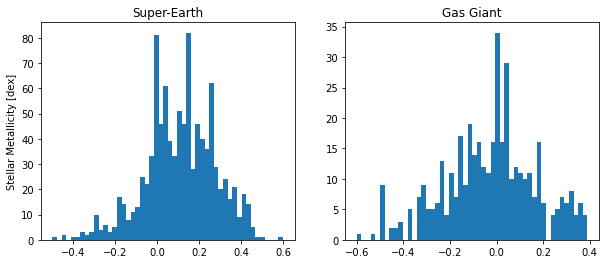

In [3]:
# Histograms forStellar Metallicity distrubution of two groups we found in Kmeans
fig = plt.figure(figsize=plt.figaspect(0.4))
ax = fig.add_subplot(1, 2, 1)
plt.title("Super-Earth")
plt.ylabel("Stellar Metallicity [dex]")
plt.hist(gaia_new['st_met'][labels==0],bins=50)

ax = fig.add_subplot(1, 2, 2)
plt.title("Gas Giant")
plt.hist(gaia_new['st_met'][labels==1],bins=50)
plt.show()

The unit often used for metallicity is the `dex`, contraction of "decimal exponent". By the formulation of chemical abundance ratios, stars with a higher metallicity than the Sun have a positive dex value, whereas those more dominated by hydrogen have a corresponding negative value.

In [4]:
# classify the metallicity into two classes: 
# dex>0 means higher metallicity than our Sun
# dex<0 means smaller metallicity than our Sun
def classify(data):
    for item in range(data.shape[0]):
        if(data[item,-1]>=0):
            data[item,-1] = 1
        else:
            data[item,-1] = 0
    return data

In [5]:
data_new = classify(gaia_np_std)

The last step in data processing is to split the data into train/test and validation data. 10% of my data is validation data.

In [6]:
X_tt, X_val, y_tt, y_val = train_test_split(data_new[:,:3], data_new[:,-1], test_size=.1, random_state=0)
test_train_data = pd.DataFrame(np.vstack((X_tt.T,y_tt)).T,columns=gaia_new.columns)
tt_np = test_train_data.to_numpy()

## Part 2: Perform 10-fold Cross Validation on SVM
 I want to find the 10-fold cross validation error for linear, radial, polynomial kernel, looking for the smallest error.

In [7]:
def compute_mse(truth_vec, predict_vec):
    return np.mean((truth_vec - predict_vec)**2)

In [8]:
def ten_fold_for_svm(data_with_classes, kernel):
    n_data = data_with_classes.shape[0]
    test_errors=[]
    k=10
    
    for i in range(k):
        #split data into train and test for 10-fold cross-val
        test_ind = list(np.arange(int(n_data*i/k),int(n_data*(i+1)/k)))
        test_data = data_with_classes[test_ind,:]
        train_ind = list(set(range(n_data)).difference(set(test_ind)))
        train_data = data_with_classes[train_ind,:]
        
        # split data to inputs and classes
        inputs = train_data[:,:3]
        classes = train_data[:,3]
        
        #Create model and fit data into model
        if(kernel == 'poly'):
            SVM = SVC(kernel='poly',degree=2,gamma='auto',C=1E1)
        else:
            SVM = SVC(kernel=kernel, C=1E1)
        SVM.fit(inputs,classes)
        
        #compute the testing error and add it to the list of testing errors
        test_preds = SVM.predict(test_data[:,:3])
        test_error = compute_mse(test_data[:,3],test_preds)
        test_errors.append(test_error)
        
    # Compute the cross-val error
    cross_val_error = np.mean(test_errors)
    return cross_val_error.astype(float)

In [9]:
print("The cross val on linear kernel is ", ten_fold_for_svm(tt_np,'linear'))
print("The cross val on rbf kernel is ", ten_fold_for_svm(tt_np,'rbf'))
print("The cross val on poly kernel is ", ten_fold_for_svm(tt_np,'poly'))

The cross val on linear kernel is  0.4196162979627546
The cross val on rbf kernel is  0.3847456567929009
The cross val on poly kernel is  0.39504436945381827


In [10]:
svm_all = SVC(kernel='rbf',gamma='auto',C=1E2)
svm_all.fit(X_tt,y_tt)

val_preds = svm_all.predict(X_val)
print("The classification error on validation dataset is", compute_mse(y_val,val_preds))

The classification error on validation dataset is 0.36879432624113473


<IPython.core.display.Javascript object>


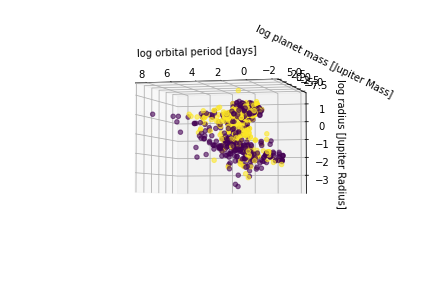

Text(0.5, 0, 'log radius [Jupiter Radius]')

In [19]:
# Plot the 3D diagram for orbit period, Jupiter Mass, and Jupiter Radius
fig = plt.figure()
ax = plt.axes(projection='3d')

# Create the SCATTER() plot 
ax.scatter(np.log(gaia_np[:,0]), np.log(gaia_np[:,1]),np.log(gaia_np[:,2]),c=data_new[:,3] ,alpha=0.6);
ax.set_xlabel('log orbital period [days]')
ax.set_ylabel('log planet mass [Jupiter Mass]')
ax.set_zlabel('log radius [Jupiter Radius]')